# Decision Trees AdaBoosting

# Boosting - Machine Learning course Classification

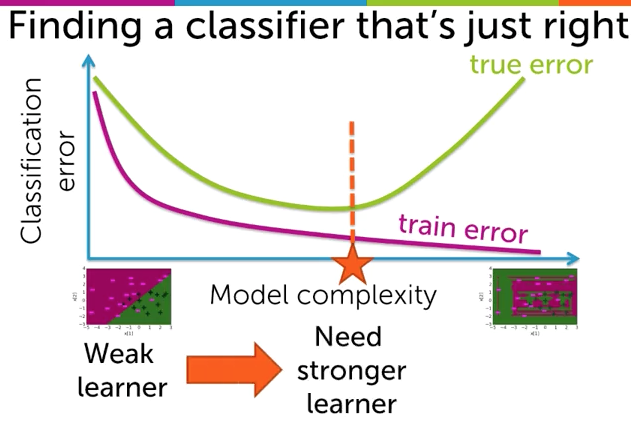

In [1]:
from IPython.display import Image
Image(filename='/Users/annalie/Dev/data-science-from-scratch/pictures/boosting-question.png')

    How?
    1. Add more features or depth
    2. Combine a set of weak classifiers to create a stronger classifier = Boosting
    
    Boosting is a type of ensemble methods.
    The idea behind ensemble methods is that multiple classifiers are weighted and combined to an overall ensemble model.

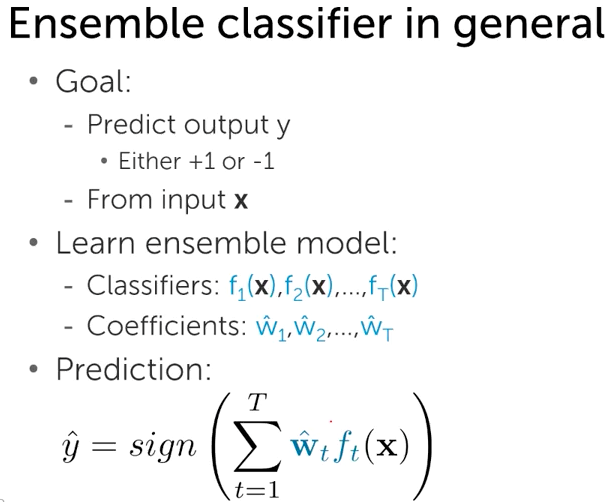

In [2]:
Image(filename='/Users/annalie/Dev/data-science-from-scratch/pictures/ensemble-classifier-model.png')

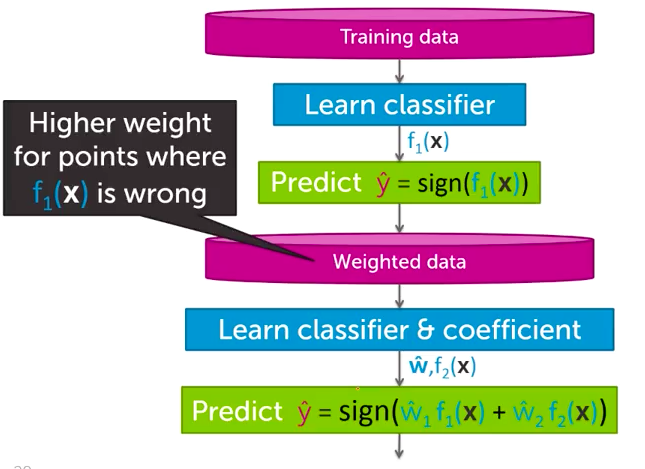

In [3]:
Image(filename='/Users/annalie/Dev/data-science-from-scratch/pictures/boosting-principle.png')

    AdaBoost is a type of boosting that starts with the same weight for all outputs.
    
    - Coefficients w are computed by how much trust you put on f(x)
    - The weights of a are recomputed for mistakes

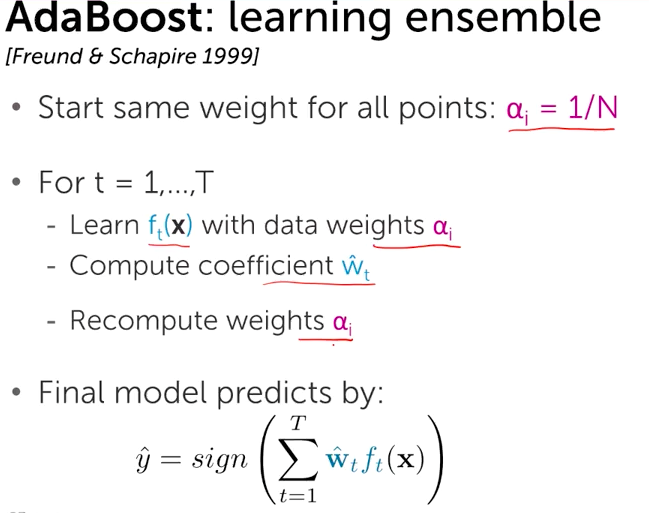

In [5]:
Image(filename='/Users/annalie/Dev/data-science-from-scratch/pictures/adaboost-model.png')

    Compute coefficient w of classifier f(x):
    
    - When f(x) is good -- larger weight on w
    - When f(x) is bad -- smaller weight on w
    
    Whether f(x) is good depends on whether f has a low training error.
    
    The weighted error measures the fraction of the weight of mistakes:
    
    weighted error = total weights of mistakes / total weight of all data points
    
    Best error is 0.0.

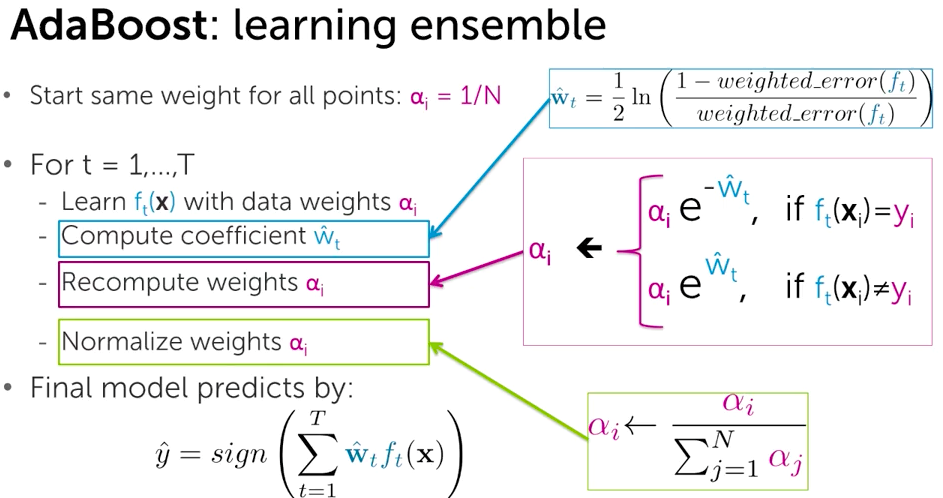

In [6]:
Image(filename='/Users/annalie/Dev/data-science-from-scratch/pictures/adaboost-formula.png')

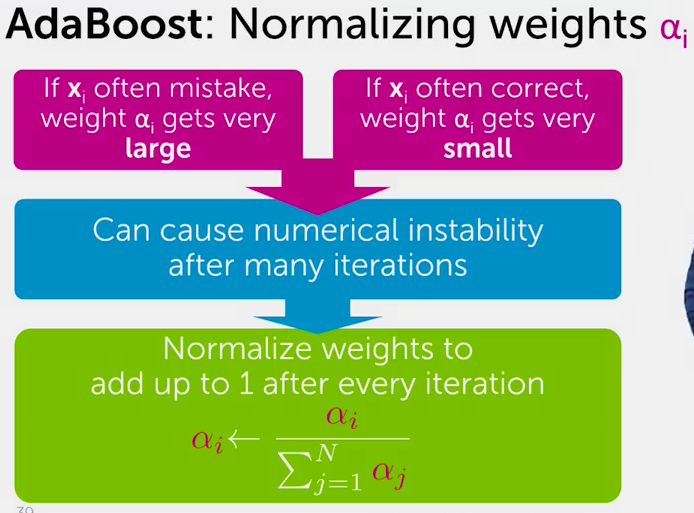

In [7]:
Image(filename='/Users/annalie/Dev/data-science-from-scratch/pictures/adaboost-normalizing.png')

# Exercise

In [11]:
import graphlab
graphlab.canvas.set_target('ipynb')
import pandas as pd
import numpy as np
import sklearn
import sklearn.tree as tree
import sklearn.ensemble.gradient_boosting as gb

In [2]:
# sframe
loans = graphlab.SFrame('/Users/annalie/Dev/data-science-from-scratch/data/lending-club-data.gl/')

In [3]:
loans.column_names()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'is_inc_v',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'not_compliant',
 'status',
 'inactive_loans',
 'bad_loans',
 'emp_length_num',
 'grade_num',
 'sub_grade_num',
 'delinq_2yrs_zero',
 'pub_rec

In [4]:
# safe loan = 1
# risky loan = -1
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.remove_column('bad_loans')

In [5]:
# select features for the boosting classification algorithm
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment'                # monthly payment owed by the borrower
           ]

In [6]:
# drop rows with missing values

loans, loans_with_na = loans[[target] + features].dropna_split()
# in pandas this would be:
# loans = loans[[target] + features].dropna()
 
# 1. count the number of rows with missing data
num_rows_with_na = loans_with_na.num_rows()
num_rows = loans.num_rows()
print 'Dropping %s observations; keeping %s ' % (num_rows_with_na, num_rows)

Dropping 29 observations; keeping 122578 


In [42]:
# make sure the classes are balanced

safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(percentage, seed = 1)
risky_loans = risky_loans_raw
loans_data = risky_loans.append(safe_loans)

print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502247166849
Percentage of risky loans                : 0.497752833151
Total number of loans in our new dataset : 46503


In [43]:
# split data into training and test set

train_data, validation_data = loans_data.random_split(.8, seed = 1)

In [44]:
# create gradient boosted tree classifier

# SFrame
model_5 = graphlab.boosted_trees_classifier.create(train_data, 
                                                   validation_set=None,
                                                   target = target, 
                                                   features = features, 
                                                   max_iterations = 5)

# # DataFrame

# # create feature set and training set
# features = [x for x in train_data.column_names() if x != "safe_loans"]
# train_features = train_data[features].to_numpy()
# train_target = train_data['safe_loans'].to_numpy()

# model_5 = gb.GradientBoostingClassifier(max_depth = 6, n_estimators = 5)
# model_5 = model_5.fit(train_features, train_target)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37219

Number of classes           : 2

Number of feature columns   : 24

Number of unpacked features : 24

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.073905     | 0.657541          | 0.657139          |

| 2         | 0.141041     | 0.656976          | 0.636157          |

| 3         | 0.208878     | 0.664983          | 0.623206          |

| 4         | 0.275761     | 0.668476          | 0.613783          |

| 5         | 0.340344     | 0.673339          | 0.606229          |

+-----------+--------------+-------------------+-------------------+

In [45]:
# make predictions

# select all positive and negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

Columns:
	safe_loans	int
	grade	str
	sub_grade_num	float
	short_emp	int
	emp_length_num	int
	home_ownership	str
	dti	float
	purpose	str
	payment_inc_ratio	float
	delinq_2yrs	int
	delinq_2yrs_zero	int
	inq_last_6mths	int
	last_delinq_none	int
	last_major_derog_none	int
	open_acc	int
	pub_rec	int
	pub_rec_zero	int
	revol_util	float
	total_rec_late_fee	float
	int_rate	float
	total_rec_int	float
	annual_inc	int
	funded_amnt	int
	funded_amnt_inv	int
	installment	float

Rows: 4

Data:
+------------+-------+---------------+-----------+----------------+----------------+
| safe_loans | grade | sub_grade_num | short_emp | emp_length_num | home_ownership |
+------------+-------+---------------+-----------+----------------+----------------+
|     1      |   B   |      0.2      |     0     |       3        |    MORTGAGE    |
|     1      |   B   |      0.6      |     1     |       1        |      RENT      |
|     -1     |   D   |      0.4      |     0     |       3        |      RENT      |
|     -1     |   A   |      1.0      |     0     |       11       |    MORTGAGE    |
+------------+-------+---------------+-----------+----------------+----------------+
+-------+--------------------+-------------------+-------------+------------------+
|  dti  |      purpose       | payment_inc_ratio | delinq_2yrs | delinq_2yrs_zero |
+-------+--------------------+-------------------+-------------+------------------+
| 29.44 |    credit_card     |      6.30496      |      0      |        1         |
| 12.19 |    credit_card     |      13.4952      |      0      |        1         |
| 13.97 |       other        |      2.96736      |      3      |        0         |
| 16.33 | debt_consolidation |      1.90524      |      0      |        1         |
+-------+--------------------+-------------------+-------------+------------------+
+----------------+------------------+-----------------------+----------+---------+
| inq_last_6mths | last_delinq_none | last_major_derog_none | open_acc | pub_rec |
+----------------+------------------+-----------------------+----------+---------+
|       0        |        1         |           1           |    8     |    0    |
|       0        |        1         |           1           |    8     |    0    |
|       0        |        0         |           1           |    14    |    0    |
|       0        |        1         |           1           |    17    |    0    |
+----------------+------------------+-----------------------+----------+---------+
+--------------+------------+--------------------+----------+-----+
| pub_rec_zero | revol_util | total_rec_late_fee | int_rate | ... |
+--------------+------------+--------------------+----------+-----+
|      1       |    93.9    |        0.0         |   9.91   | ... |
|      1       |    59.1    |        0.0         |  11.71   | ... |
|      1       |    59.5    |        0.0         |  16.77   | ... |
|      1       |    62.1    |        0.0         |   8.9    | ... |
+--------------+------------+--------------------+----------+-----+
[4 rows x 25 columns]

In [46]:
# predict whether the loan is classified as a safe loan

model_5.predict(sample_validation_data)

dtype: int
Rows: 4
[1, 1, -1, 1]

In [47]:
# predict the probability of a loan being classified as a safe loan

[round(x,2) for x in model_5.predict(sample_validation_data, output_type='probability')]

[0.7, 0.6, 0.45, 0.61]

In [48]:
# evaluate the accuracy of the model_5 on the validation_data

model_5.evaluate(validation_data)

{'accuracy': 0.66813873330461,
 'auc': 0.7247215702188436,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      -1      |        1        |  1618 |
 |      1       |        -1       |  1463 |
 |      -1      |        -1       |  3054 |
 |      1       |        1        |  3149 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6715001599317625,
 'log_loss': 0.617613176969398,
 'precision': 0.6605831760016782,
 'recall': 0.6827840416305291,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 4612 | 4672 |
 |   1e-05   | 1.0 | 1.0 | 4612 | 4672 |
 |   2e-05   | 1.0 | 1

In [49]:
# calculate the number of false positives made by the model
# = predicted as safe loan, but in fact risky loan 

false_positives = sum(model_5.predict(validation_risky_loans) == +1) # inncorrectly predicted as a safe loan
false_positives

1618

In [50]:
# calculate the number of false negatives made by the model
# = predicted as risky loan, but in fact safe loan

false_negatives = sum(model_5.predict(validation_safe_loans) == -1)
false_negatives

1463

In [51]:
# calculate the accuracy manually

print "accuracy:", round(1-float(false_negatives+false_positives)/len(validation_data), 2)

accuracy: 0.67


In [52]:
# find the loans that are most likely to be predicted safe

# make probability predictions for all the loans in the validation_data and 
# add the outcomes into a new column of the validation_data
validation_data['predictions'] = model_5.predict(validation_data, output_type='probability')

In [53]:
print "Your loans      : %s\n" % validation_data['predictions'].head(4)
print "Expected answer : %s" % [0.4492515948736132, 0.6119100103640573,
                                0.3835981314851436, 0.3693306705994325]

Your loans      : [0.44925159215927124, 0.6119099855422974, 0.38359811902046204, 0.3693307042121887]

Expected answer : [0.4492515948736132, 0.6119100103640573, 0.3835981314851436, 0.3693306705994325]


In [55]:
# sort the data (in descreasing order) by the probability predictions

sorted_loans_desc =  validation_data.sort(sort_columns='predictions', ascending=False)
sorted_loans_desc['predictions'].head(5)
sorted_loans_desc.head(5)

Columns:
	safe_loans	int
	grade	str
	sub_grade_num	float
	short_emp	int
	emp_length_num	int
	home_ownership	str
	dti	float
	purpose	str
	payment_inc_ratio	float
	delinq_2yrs	int
	delinq_2yrs_zero	int
	inq_last_6mths	int
	last_delinq_none	int
	last_major_derog_none	int
	open_acc	int
	pub_rec	int
	pub_rec_zero	int
	revol_util	float
	total_rec_late_fee	float
	int_rate	float
	total_rec_int	float
	annual_inc	int
	funded_amnt	int
	funded_amnt_inv	int
	installment	float
	predictions	float

Rows: 5

Data:
+------------+-------+---------------+-----------+----------------+----------------+
| safe_loans | grade | sub_grade_num | short_emp | emp_length_num | home_ownership |
+------------+-------+---------------+-----------+----------------+----------------+
|     1      |   A   |      0.2      |     0     |       11       |    MORTGAGE    |
|     1      |   A   |      0.4      |     0     |       4        |    MORTGAGE    |
|     1      |   A   |      0.2      |     0     |       6        |    MORTGAGE    |
|     1      |   A   |      0.2      |     0     |       8        |    MORTGAGE    |
|     1      |   A   |      0.6      |     0     |       6        |    MORTGAGE    |
+------------+-------+---------------+-----------+----------------+----------------+
+-------+------------------+-------------------+-------------+------------------+
|  dti  |     purpose      | payment_inc_ratio | delinq_2yrs | delinq_2yrs_zero |
+-------+------------------+-------------------+-------------+------------------+
|  4.21 |   credit_card    |      0.955726     |      0      |        1         |
| 12.76 |       car        |       1.7376      |      0      |        1         |
| 10.29 | home_improvement |      3.22264      |      0      |        1         |
| 10.02 |     wedding      |      3.49357      |      0      |        1         |
|  3.16 | home_improvement |      2.91713      |      0      |        1         |
+-------+------------------+-------------------+-------------+------------------+
+----------------+------------------+-----------------------+----------+---------+
| inq_last_6mths | last_delinq_none | last_major_derog_none | open_acc | pub_rec |
+----------------+------------------+-----------------------+----------+---------+
|       2        |        1         |           1           |    9     |    0    |
|       2        |        1         |           1           |    11    |    0    |
|       1        |        1         |           1           |    14    |    0    |
|       0        |        1         |           1           |    14    |    0    |
|       0        |        1         |           1           |    16    |    0    |
+----------------+------------------+-----------------------+----------+---------+
+--------------+------------+--------------------+----------+-----+
| pub_rec_zero | revol_util | total_rec_late_fee | int_rate | ... |
+--------------+------------+--------------------+----------+-----+
|      1       |    7.9     |        0.0         |   6.39   | ... |
|      1       |    5.5     |        0.0         |   6.76   | ... |
|      1       |    4.5     |        0.0         |   6.03   | ... |
|      1       |    7.9     |        0.0         |   6.03   | ... |
|      1       |    5.0     |        0.0         |   7.14   | ... |
+--------------+------------+--------------------+----------+-----+
[5 rows x 26 columns]

In [56]:
# show the grades of the top 5 loans with the highest probability of being predicted as a safe loan
validation_data.sort('predictions', 0)['grade'].head(5)

dtype: str
Rows: 5
['A', 'A', 'A', 'A', 'A']

In [57]:
# show the top 5 loans with the lowest probability of being predicted as a safe loan
validation_data.sort('predictions', 0)['grade'].tail(5)

dtype: str
Rows: 5
['C', 'B', 'D', 'C', 'C']

# Effect of adding more trees

    Train models with 10, 50, 100, 200, and 500 trees. 

In [58]:
model_10 = graphlab.boosted_trees_classifier.create(train_data, 
                                                    validation_set=None, 
                                                    target = target, 
                                                    features = features, 
                                                    max_iterations = 10, 
                                                    verbose=False)

model_50 = graphlab.boosted_trees_classifier.create(train_data, 
                                                    validation_set=None, 
                                                    target = target, 
                                                    features = features, 
                                                    max_iterations = 50, 
                                                    verbose=False)

model_100 = graphlab.boosted_trees_classifier.create(train_data, 
                                                    validation_set=None, 
                                                    target = target, 
                                                    features = features, 
                                                    max_iterations = 100, 
                                                    verbose=False)

model_200 = graphlab.boosted_trees_classifier.create(train_data, 
                                                    validation_set=None, 
                                                    target = target, 
                                                    features = features, 
                                                    max_iterations = 200, 
                                                    verbose=False)

model_500 = graphlab.boosted_trees_classifier.create(train_data, 
                                                    validation_set=None, 
                                                    target = target, 
                                                    features = features, 
                                                    max_iterations = 500, 
                                                    verbose=False)

In [61]:
# compare accuracy of the different models on the entire data set

for i in [model_10, model_50, model_100, model_200, model_500]:
    print i.max_iterations, i.evaluate(validation_data)['accuracy']

10 0.672770357604
50 0.690758293839
100 0.691727703576
200 0.684510986644
500 0.671800947867


# Plot the training and validation error vs. number of trees

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [72]:
# create lists of the accuracies

# 1. calculate the classification error for model on the training data and
# 2. store the training errors into a list

# do the same for model on the validation data

# classification error for training data
train_err_10 = model_10.evaluate(train_data)['accuracy']
train_err_50 = model_50.evaluate(train_data)['accuracy']
train_err_100 = model_100.evaluate(train_data)['accuracy']
train_err_200 = model_200.evaluate(train_data)['accuracy']
train_err_500 = model_500.evaluate(train_data)['accuracy']

training_errors = [train_err_10, train_err_50, train_err_100, train_err_200, train_err_500]

# classification error for validation data
val_err_10 = model_10.evaluate(validation_data)['accuracy']
val_err_50 = model_50.evaluate(validation_data)['accuracy']
val_err_100 = model_100.evaluate(validation_data)['accuracy']
val_err_200 = model_200.evaluate(validation_data)['accuracy']
val_err_500 = model_500.evaluate(validation_data)['accuracy']

validation_errors = [val_err_10, val_err_50, val_err_100, val_err_200, val_err_500]

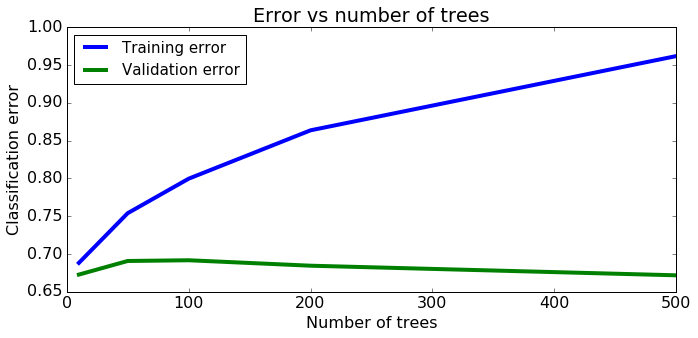

In [73]:
# plot the training errors and validation erros versus the number of trees

plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

# Decision tree versus Boosting method

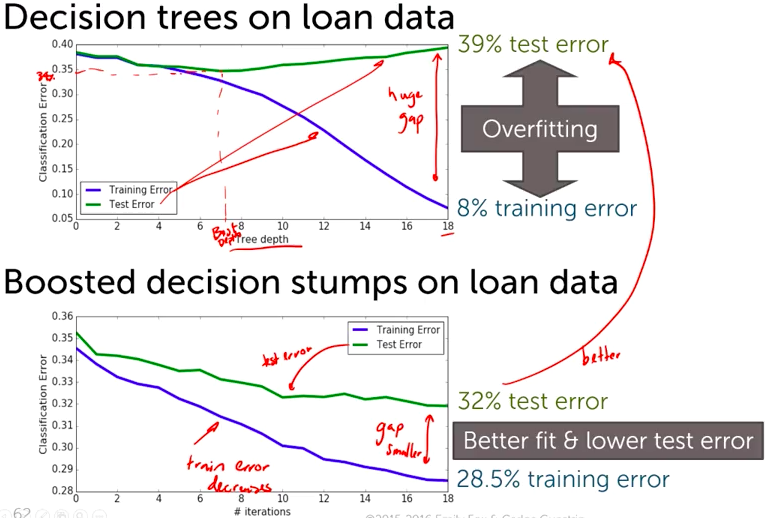

In [75]:
Image(filename='/Users/annalie/Dev/data-science-from-scratch/pictures/decision-tree-vs-boosting.png')

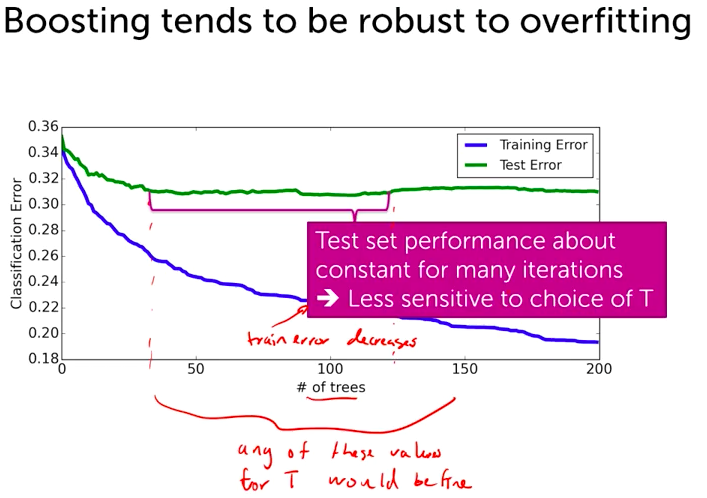

In [76]:
Image(filename='/Users/annalie/Dev/data-science-from-scratch/pictures/boosting-overfitting-1.png')

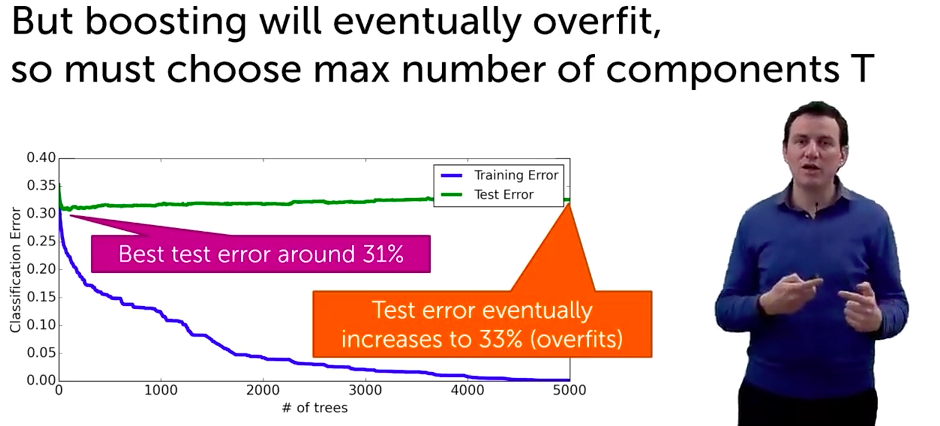

In [77]:
Image(filename='/Users/annalie/Dev/data-science-from-scratch/pictures/boosting-overfitting-2.png')

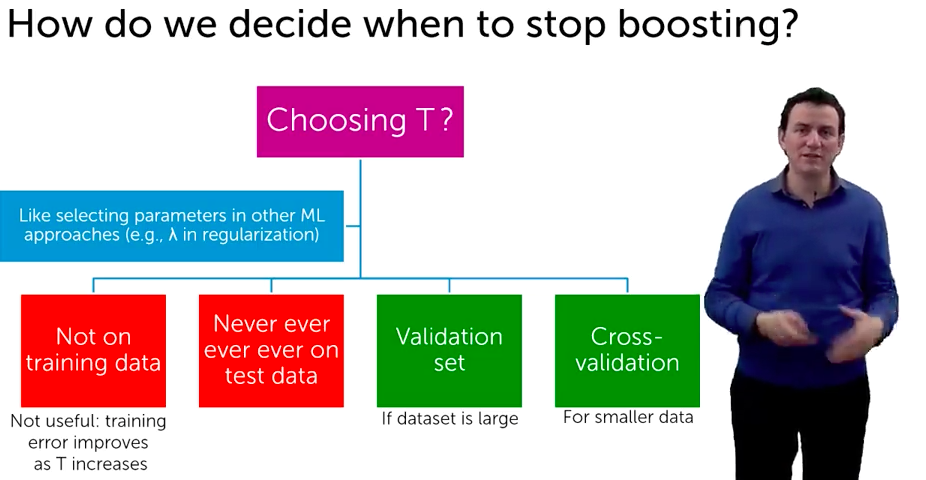

In [78]:
Image(filename='/Users/annalie/Dev/data-science-from-scratch/pictures/stop-boosting.png')

# Implement your own boosting module.

    - Use SFrames to do some feature engineering.
    - Modify the decision trees to incorporate weights.
    - Implement Adaboost ensembling.
    - Use your implementation of Adaboost to train a boosted decision stump ensemble.
    - Evaluate the effect of boosting (adding more decision stumps) on performance of the model.
    - Explore the robustness of Adaboost to overfitting.

In [3]:
import graphlab
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# sframe
loans = graphlab.SFrame('/Users/annalie/Dev/data-science-from-scratch/data/lending-club-data.gl/')

In [5]:
# extract target and feature columns

features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.remove_column('bad_loans')
target = 'safe_loans'
loans = loans[features + [target]]

In [6]:
# subsample dataset to make sure classes are balanced

safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# undersample the safe loans
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(percentage, seed=1)
loans_data = risky_loans_raw.append(safe_loans)

print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502236174422
Percentage of risky loans                : 0.497763825578
Total number of loans in our new dataset : 46508


In [7]:
# transform categorical data into binary features

loans_data = risky_loans.append(safe_loans)
for feature in features:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})    
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)
    
    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data.remove_column(feature)
    loans_data.add_columns(loans_data_unpacked)

In [8]:
# show the dummy features
features = loans_data.column_names()
features.remove('safe_loans')  # Remove the response variable
features

['grade.A',
 'grade.B',
 'grade.C',
 'grade.D',
 'grade.E',
 'grade.F',
 'grade.G',
 'term. 36 months',
 'term. 60 months',
 'home_ownership.MORTGAGE',
 'home_ownership.OTHER',
 'home_ownership.OWN',
 'home_ownership.RENT',
 'emp_length.1 year',
 'emp_length.10+ years',
 'emp_length.2 years',
 'emp_length.3 years',
 'emp_length.4 years',
 'emp_length.5 years',
 'emp_length.6 years',
 'emp_length.7 years',
 'emp_length.8 years',
 'emp_length.9 years',
 'emp_length.< 1 year',
 'emp_length.n/a']

In [9]:
# split data into training and test set

train_data, test_data = loans_data.random_split(0.8, seed=1)

# Weighted decision trees

In [10]:
# Write a function to compute weight of mistakes

def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    if weighted_mistakes_all_negative < weighted_mistakes_all_positive:
        return (weighted_mistakes_all_negative,-1)
    else:
        return (weighted_mistakes_all_positive,+1)

In [11]:
# Write a function to pick best feature to split on

def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        # Calculate the weight of mistakes for left and right sides
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(
            left_split[target], left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(
            right_split[target], right_data_weights)
        
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        error = (left_weighted_mistakes + right_weighted_mistakes) / sum(data_weights)
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

# Building the tree

In [12]:
# Write a function that creates a leaf node given a set of target values

def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class
    
    return leaf 

In [13]:
# Write a function that learns a weighted decision tree recursively and implements 3 stopping conditions:

# 1. All data points in a node are from the same class
# 2. No more features to split on
# 3. Stop growing the tree when the tree depth reaches max_depth

def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print "--------------------------------------------------------------------"
    print "Subtree, depth = %s (%s data points)." % (current_depth, len(target_values))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print "Stopping condition 1 reached."                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print "Stopping condition 2 reached."                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print "Reached maximum depth. Stopping for now."
        return create_leaf(target_values, data_weights)
    
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print "Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print "Creating leaf node."
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print "Creating leaf node."
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

In [14]:
# Write a function to count the nodes in the tree

def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [15]:
# example

example_data_weights = graphlab.SArray([1.0 for i in range(len(train_data))])
small_data_decision_tree = weighted_decision_tree_create(train_data, features, target,
                                                         example_data_weights, max_depth=2)
if count_nodes(small_data_decision_tree) == 7:
    print 'Test passed!'
else:
    print 'Test failed... try again!'
    print 'Number of nodes found:', count_nodes(small_data_decision_tree)
    print 'Number of nodes that should be there: 7' 

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Split on feature grade.A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 3 (9122 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (101 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Split on feature grade.D. (23300, 4701)
--------------------------------------------------------------------
Subtree, depth = 3 (23300 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (4701 data po

In [16]:
small_data_decision_tree

{'is_leaf': False,
 'left': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'grade.A'},
 'prediction': None,
 'right': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'splitting_feature': 'grade.D'},
 'splitting_feature': 'term. 36 months'}

# Making predictions with a weigthed decision tree

In [18]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print "At leaf, predicting %s" % tree['prediction']
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print "Split on %s = %s" % (tree['splitting_feature'], split_feature_value)
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

# Evaluate the tree

In [19]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x))
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [20]:
evaluate_classification_error(small_data_decision_tree, test_data)

0.3981042654028436

# Example: Training a weighted decision tree

    Suppose we only care about making good predictions for the first 10 and last 10 items in train_data, 
    we assign weights:
        - 1 to the last 10 items
        - 1 to the first 10 items
        - 0 to the rest.
    Let us fit a weighted decision tree with max_depth = 2.

In [21]:
# Assign weights
example_data_weights = graphlab.SArray([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)

# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                                                                   example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature home_ownership.RENT. (20514, 16710)
--------------------------------------------------------------------
Subtree, depth = 2 (20514 data points).
Split on feature grade.F. (19613, 901)
--------------------------------------------------------------------
Subtree, depth = 3 (19613 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (901 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (16710 data points).
Split on feature grade.D. (13315, 3395)
--------------------------------------------------------------------
Subtree, depth = 3 (13315 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (3395 data points).
Stoppin

In [22]:
# compute the classification error on a subset of data points whose weight is 1 (the first and last 10 data points)

subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.05

    The model small_data_decision_tree_subset_20 performs a lot better on subset_20 than on train_data.
    This is because:
        
        - The points with higher weights are the ones that are more important during the training process of 
          the weighted decision tree.
        - The points with zero weights are basically ignored during training.

# Implement AdaBoost on decision stumps

1\. Start with unweighted data with $\alpha_j = 1$

2\. For t = 1,...T:
  * Learn $f_t(x)$ with data weights $\alpha_j$
  * Compute coefficient $\hat{w}_t$:
     $$\hat{w}_t = \frac{1}{2}\ln{\left(\frac{1- \mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}\right)}$$
  * Re-compute weights $\alpha_j$:
     $$\alpha_j \gets \begin{cases}
     \alpha_j \exp{(-\hat{w}_t)} & \text{ if }f_t(x_j) = y_j\\
     \alpha_j \exp{(\hat{w}_t)} & \text{ if }f_t(x_j) \neq y_j
     \end{cases}$$
  * Normalize weights $\alpha_j$:
      $$\alpha_j \gets \frac{\alpha_j}{\sum_{i=1}^{N}{\alpha_i}} $$

In [25]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = graphlab.SArray([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in xrange(num_tree_stumps):
        print '====================================================='
        print 'Adaboost Iteration %d' % t
        print '====================================================='        
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = data.apply(lambda x: classify(tree_stump, x))
        
        # Produce a Boolean array indicating whether each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        weighted_error = sum(a for i, a in enumerate(alpha) if is_wrong[i])/sum(alpha)
        print weighted_error
        
        # Compute model coefficient using weighted error
        weight = log((1-weighted_error)/weighted_error)/2
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment 
        # Then normalize data points weights        
        sum_alpha = sum(alpha)
        alpha = alpha*adjustment/sum_alpha
    
    return weights, tree_stumps

In [26]:
# Check AdaBoosting code
# training a boosted ensemble with 2 tree stumps

stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
0.421636578551
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
0.412498248915


In [27]:
def print_stump(tree):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print "(leaf, label: %s)" % tree['prediction']
        return None
    split_feature, split_value = split_name.split('.')
    print '                       root'
    print '         |---------------|----------------|'
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '  [{0} == 0]{1}[{0} == 1]    '.format(split_name, ' '*(27-len(split_name)))
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '    (%s)                 (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree'))

In [31]:
# print the first stump
print_stump(tree_stumps[0])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term. 36 months == 0]            [term. 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [32]:
# print the next stump
print_stump(tree_stumps[1])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade.A == 0]                    [grade.A == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [33]:
# print weights of the stumps
print stump_weights

[0.15802933659263743, 0.17682363293605327]


**Reminders**
- Stump weights (ŵ ) and data point weights (α) are two different concepts.
- Stump weights (ŵ ) tell you how important each stump is while making predictions with the entire 
  boosted ensemble.
- Data point weights (α) tell you how important each data point is while training a decision stump.

# Training a boosted ensemble with 10 tree stumps

In [34]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features,
                                                       target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
0.421636578551
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
0.412498248915
Adaboost Iteration 2
---

# Making predictions
    
In order to make predictions, use the following formula:
$$
\hat{y} = sign\left(\sum_{t=1}^T \hat{w}_t f_t(x)\right)
$$

- Compute the predictions $f_t(x)$ using the $t$-th decision tree
- Compute $\hat{w}_t f_t(x)$ by multiplying the `stump_weights` with the predictions $f_t(x)$ from the decision trees
- Sum the weighted predictions over each stump in the ensemble.

In [35]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = graphlab.SArray([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x))
        
        # Accumulate predictions on scores array
        scores = scores + (stump_weights[i] * predictions)
        
    return scores.apply(lambda score : +1 if score > 0 else -1)

In [36]:
predictions = predict_adaboost(stump_weights, tree_stumps, test_data)
accuracy = graphlab.evaluation.accuracy(test_data[target], predictions)
print 'Accuracy of 10-component ensemble = %s' % accuracy 

Accuracy of 10-component ensemble = 0.620314519604


In [37]:
# show how the stump_weights look like at the end of each iteration of the 10-stump ensemble:
stump_weights

[0.15802933659263743,
 0.17682363293605327,
 0.09311888971195705,
 0.0728888552581495,
 0.06706306914131716,
 0.06456916961613322,
 0.05456055779221647,
 0.04351093673354489,
 0.028988711500059067,
 0.0259625096913776]

**Reminder**: Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.

# Performance plots

### How does accuracy change with adding stumps to the ensemble?

Train an ensemple with 30 tree stumps.

- Compute the classification error at the end of each iteration.
- Plot a curve of classification error vs iteration.

In [39]:
# train an ensemble with 30 tree stumps
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
0.421636578551
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
0.412498248915
Adaboost Iteration 2
---

In [40]:
# Computing training error at the end of each iteration

error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = 1.0 - graphlab.evaluation.accuracy(train_data[target], predictions)
    error_all.append(error)
    print "Iteration %s, training error = %s" % (n, error_all[n-1])

Iteration 1, training error = 0.421636578551
Iteration 2, training error = 0.433430045132
Iteration 3, training error = 0.400037610144
Iteration 4, training error = 0.400037610144
Iteration 5, training error = 0.384724908661
Iteration 6, training error = 0.384617451107
Iteration 7, training error = 0.382763808296
Iteration 8, training error = 0.384617451107
Iteration 9, training error = 0.382763808296
Iteration 10, training error = 0.384483129164
Iteration 11, training error = 0.382736943907
Iteration 12, training error = 0.381447453256
Iteration 13, training error = 0.381528046422
Iteration 14, training error = 0.380560928433
Iteration 15, training error = 0.380507199656
Iteration 16, training error = 0.378223726628
Iteration 17, training error = 0.378277455405
Iteration 18, training error = 0.378411777348
Iteration 19, training error = 0.378062540297
Iteration 20, training error = 0.378761014399
Iteration 21, training error = 0.379566946056
Iteration 22, training error = 0.3788953363

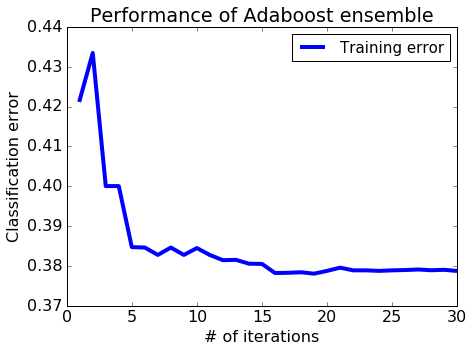

In [41]:
# Visualizing training error vs number of iterations

plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

In [42]:
# evaluate on the test data

test_error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = 1.0 - graphlab.evaluation.accuracy(test_data[target], predictions)
    test_error_all.append(error)
    print "Iteration %s, test error = %s" % (n, test_error_all[n-1])

Iteration 1, test error = 0.42330891857
Iteration 2, test error = 0.428479103835
Iteration 3, test error = 0.398104265403
Iteration 4, test error = 0.398104265403
Iteration 5, test error = 0.379900904782
Iteration 6, test error = 0.380008616975
Iteration 7, test error = 0.379254631624
Iteration 8, test error = 0.380008616975
Iteration 9, test error = 0.379254631624
Iteration 10, test error = 0.379685480396
Iteration 11, test error = 0.379254631624
Iteration 12, test error = 0.377962085308
Iteration 13, test error = 0.379254631624
Iteration 14, test error = 0.377854373115
Iteration 15, test error = 0.378500646273
Iteration 16, test error = 0.377854373115
Iteration 17, test error = 0.377962085308
Iteration 18, test error = 0.377854373115
Iteration 19, test error = 0.378177509694
Iteration 20, test error = 0.376884963378
Iteration 21, test error = 0.377531236536
Iteration 22, test error = 0.376777251185
Iteration 23, test error = 0.376777251185
Iteration 24, test error = 0.376884963378
It

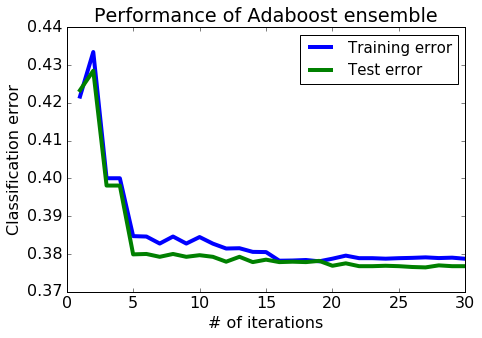

In [43]:
# Visualize both the training and test errors

plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()

No sign of overfitting with this AdaBoost example.